100%|██████████| 6/6 [00:00<00:00, 15.04it/s]


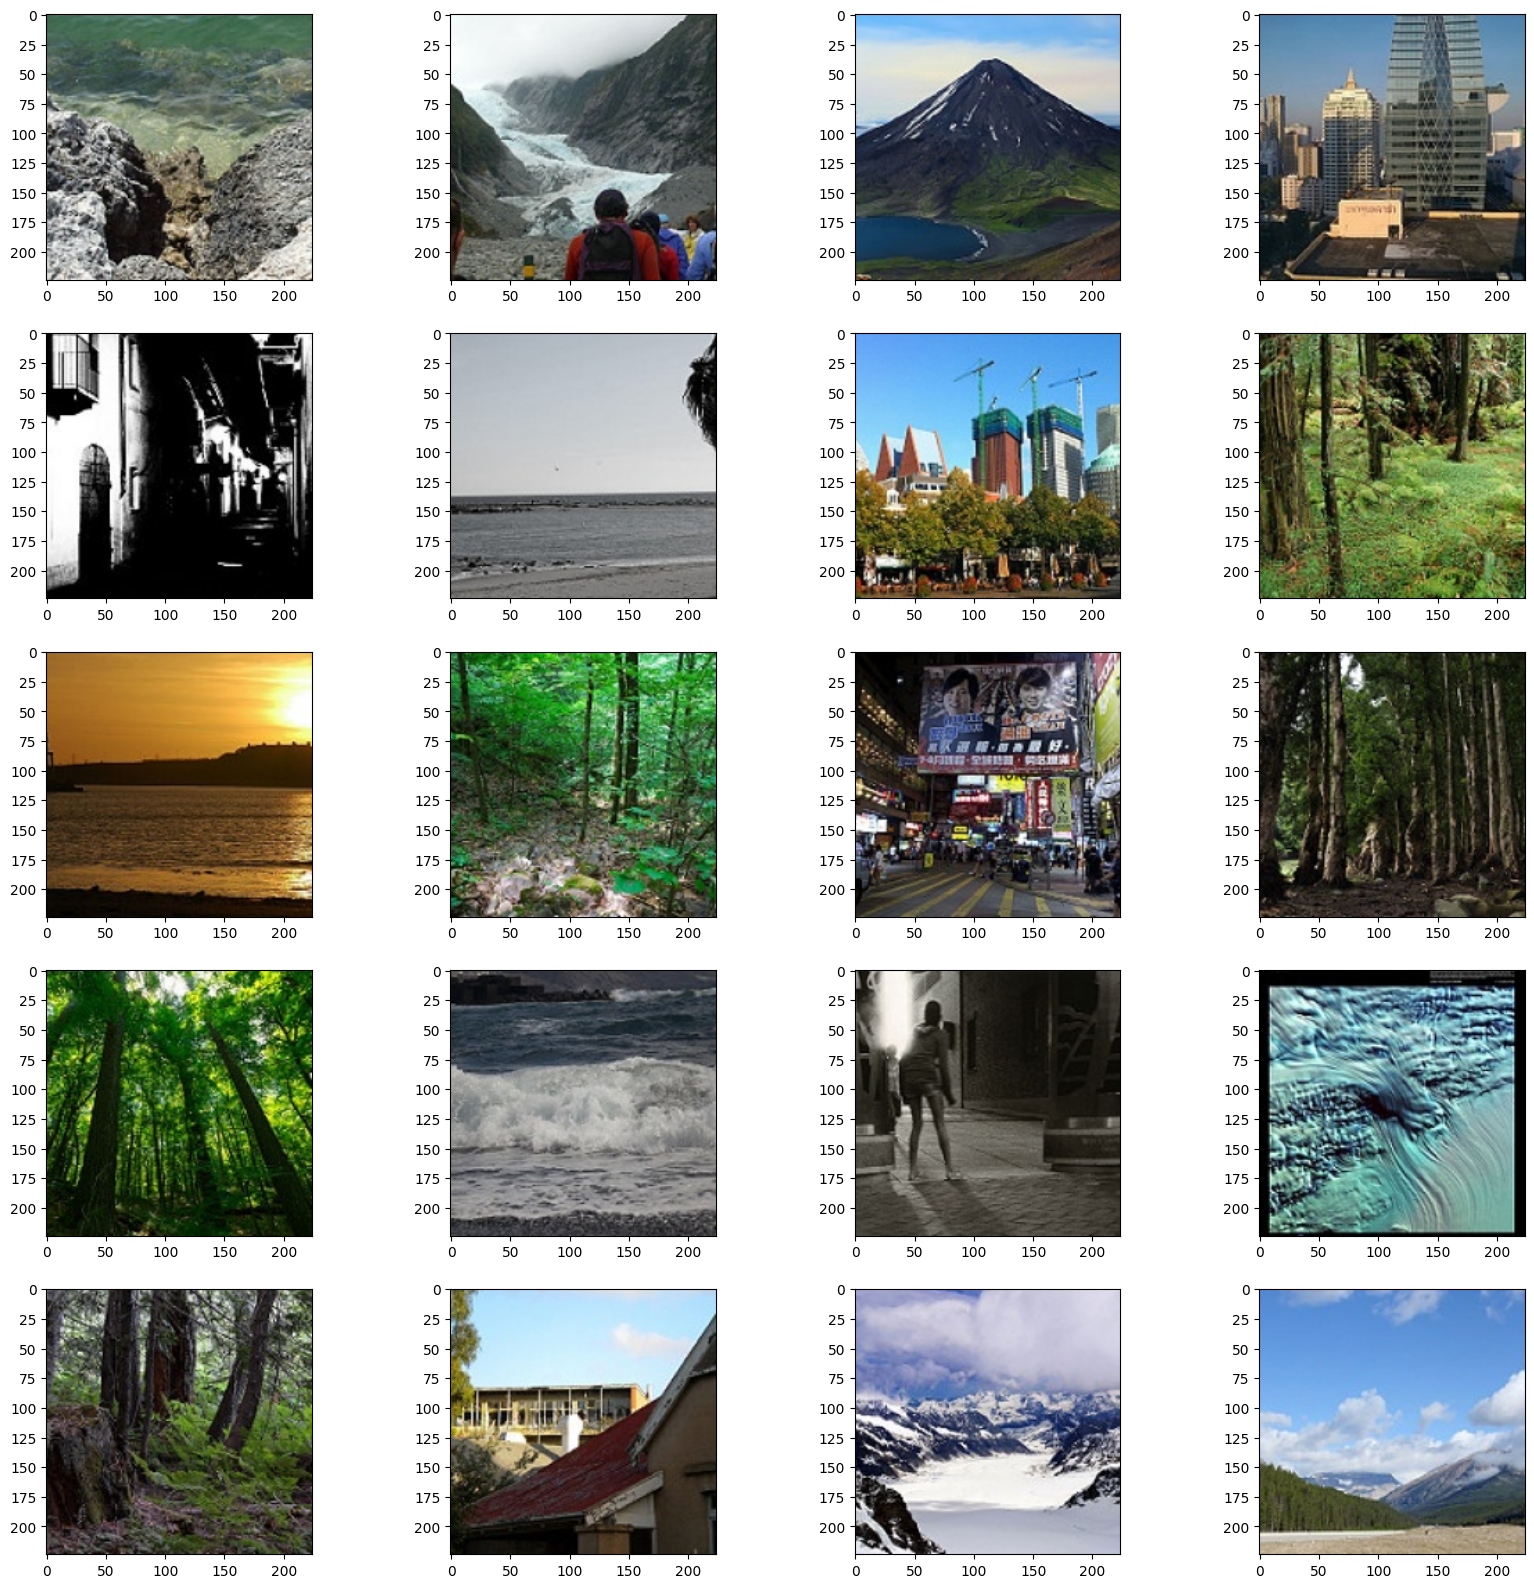

In [1]:
# make the data ready 
from tqdm import tqdm
import os 
data_path = '/kaggle/input/intel-image-classification/seg_test/seg_test'
images_full_paths = []
for folder in tqdm(os.listdir(data_path)):
    folder = os.path.join(data_path, folder)
    image_from_folder = []
    for file in os.listdir(folder):
        image_from_folder.append(os.path.join(folder, file))
    images_full_paths.append(image_from_folder)

# take random image 10 images from each folder save in quwery folder
import random
import shutil
query_path = 'query'
if not os.path.exists(query_path):
    os.mkdir(query_path)
for images in images_full_paths:
    random_images = random.sample(images, 10)
    for image in random_images:
        shutil.copy(image, query_path)

query_images = [os.path.join(query_path, file) for file in os.listdir(query_path)]

#plot random images
import matplotlib.pyplot as plt
import cv2
import numpy as np
fig = plt.figure(figsize=(20, 20))
rows = 5
columns = 4
for i in range(1, rows*columns+1):
    img = cv2.imread(query_images[i-1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    

In [2]:
import torch
from transformers import CLIPImageProcessor, CLIPModel, CLIPTokenizer

from PIL import Image
import cv2
import numpy as np
import argparse
from matplotlib import pyplot as plt
from tqdm import tqdm
import os

In [3]:
model_ID = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_ID)
preprocess = CLIPImageProcessor.from_pretrained(model_ID)

def load_and_preprocess_images(image_paths):
    images = [Image.open(image_path) for image_path in image_paths]
    preprocessed_images = [preprocess(image, return_tensors="pt")["pixel_values"] for image in images]
    return torch.cat(preprocessed_images)

# Path to the image to compare
image_to_compare_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/forest/10186.jpg'

# Path to the folder containing the images
folder_path = query_path

# Get the paths to all images in the folder
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.png') or filename.endswith('.jpg')]

# Add the image to compare to the list of image paths
image_paths = [image_to_compare_path] + image_paths

# Load and preprocess all images
images = load_and_preprocess_images(image_paths)

In [4]:
with torch.no_grad():
    # Calculate the embeddings for all images
    embeddings = model.get_image_features(images)

# Calculate the cosine similarity between the embeddings of the image to compare and each image in the folder
similarity_scores = torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1:])

# Get the indices of the top 10 similarity scores
top_10_indices = torch.topk(similarity_scores, 10).indices

# Get the paths to the top 10 similar images
top_10_image_paths = [image_paths[i+1] for i in top_10_indices]

print(top_10_image_paths)

['query/22128.jpg', 'query/20938.jpg', 'query/20328.jpg', 'query/21018.jpg', 'query/20785.jpg', 'query/22833.jpg', 'query/22125.jpg', 'query/20330.jpg', 'query/21994.jpg', 'query/21345.jpg']


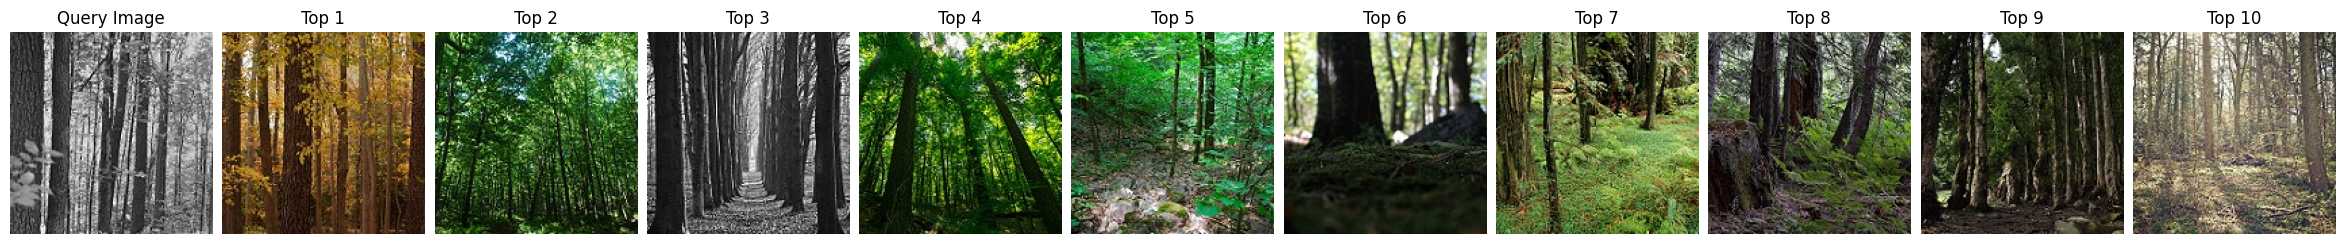

In [5]:
# Plot the query image
fig = plt.figure(figsize=(30, 20))  # Increase the size of the figure
plt.subplot(1, 11, 1)
plt.imshow(Image.open(image_to_compare_path))
plt.title("Query Image")
plt.axis('off')

# Plot the top 10 similar images
for i, image_path in enumerate(top_10_image_paths, start=2):
    plt.subplot(1, 11, i)
    plt.imshow(Image.open(image_path))
    plt.title(f"Top {i-1}")
    plt.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

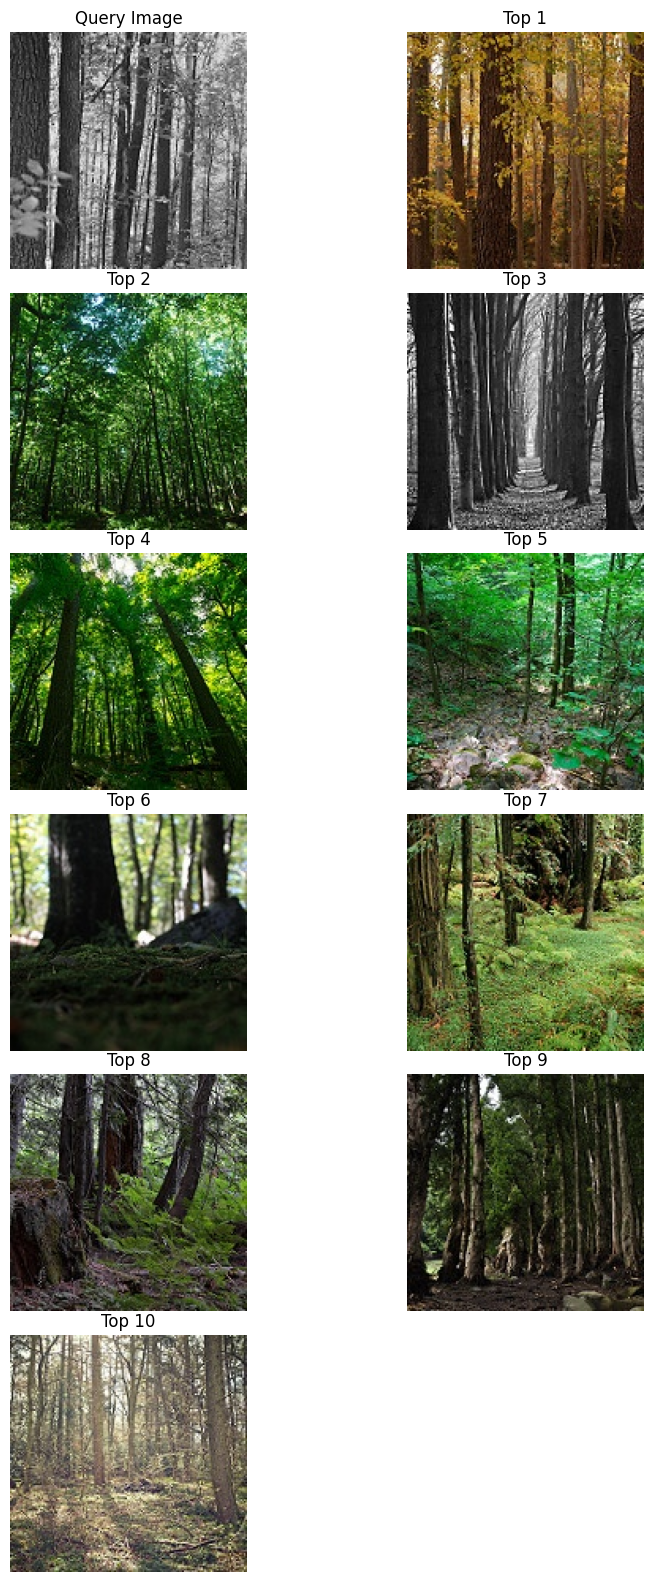

In [6]:
# Create a new array with the query image at index 0
image_paths = [image_to_compare_path] + top_10_image_paths

# Create a figure
fig = plt.figure(figsize=(10, 20))

# Plot the images in two columns
num_rows = 6  # Number of rows for the images
num_cols = 2  # Number of columns for the images

for i, image_path in enumerate(image_paths):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(Image.open(image_path))
    plt.title("Query Image" if i == 0 else f"Top {i}")
    plt.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Display the figure
plt.show()

In [7]:
from transformers import AutoImageProcessor, AutoModel
import random


# face recognation 
celebA_path = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'
faces = os.listdir(celebA_path)

# select 1000 faces
query_faces = random.sample(faces, 100)

# load model
model_name = 'google/vit-base-patch16-224-in21k'
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [8]:
# extract features
features = {
    'image_pth': [],
    'features': []
}
for face in tqdm(query_faces):
    image_pth = os.path.join(celebA_path, face)
    image = Image.open(image_pth)
    inputs = processor(images=[image], return_tensors='pt')  # Pass the image as a list
    embedding = model(**inputs).last_hidden_state[:, 0]
    features['image_pth'].append(image_pth)
    features['features'].append(embedding)



100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


In [9]:
# features['features'][0]

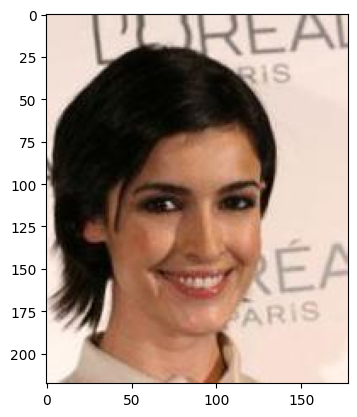

In [10]:
# get query image
query_face = random.sample(query_faces, 1)[0]
query_image_pth = os.path.join(celebA_path, query_face)
query_image = Image.open(query_image_pth)
plt.imshow(query_image)
plt.show()


In [11]:
# get query feature
query_inputs = processor(images=[query_image], return_tensors='pt')
query_embedding = model(**query_inputs).last_hidden_state[:, 0]


In [12]:
# calculate similarity
similarities = []
for feature in features['features']:
    similarity = torch.cosine_similarity(feature, query_embedding, dim=1)
    similarities.append(similarity)

In [13]:
# get top 10 similar faces
similarities = torch.cat(similarities, dim=0)
top_10_similarities, top_10_indices = torch.topk(similarities, 10)
top_10_faces = [features['image_pth'][i] for i in top_10_indices]


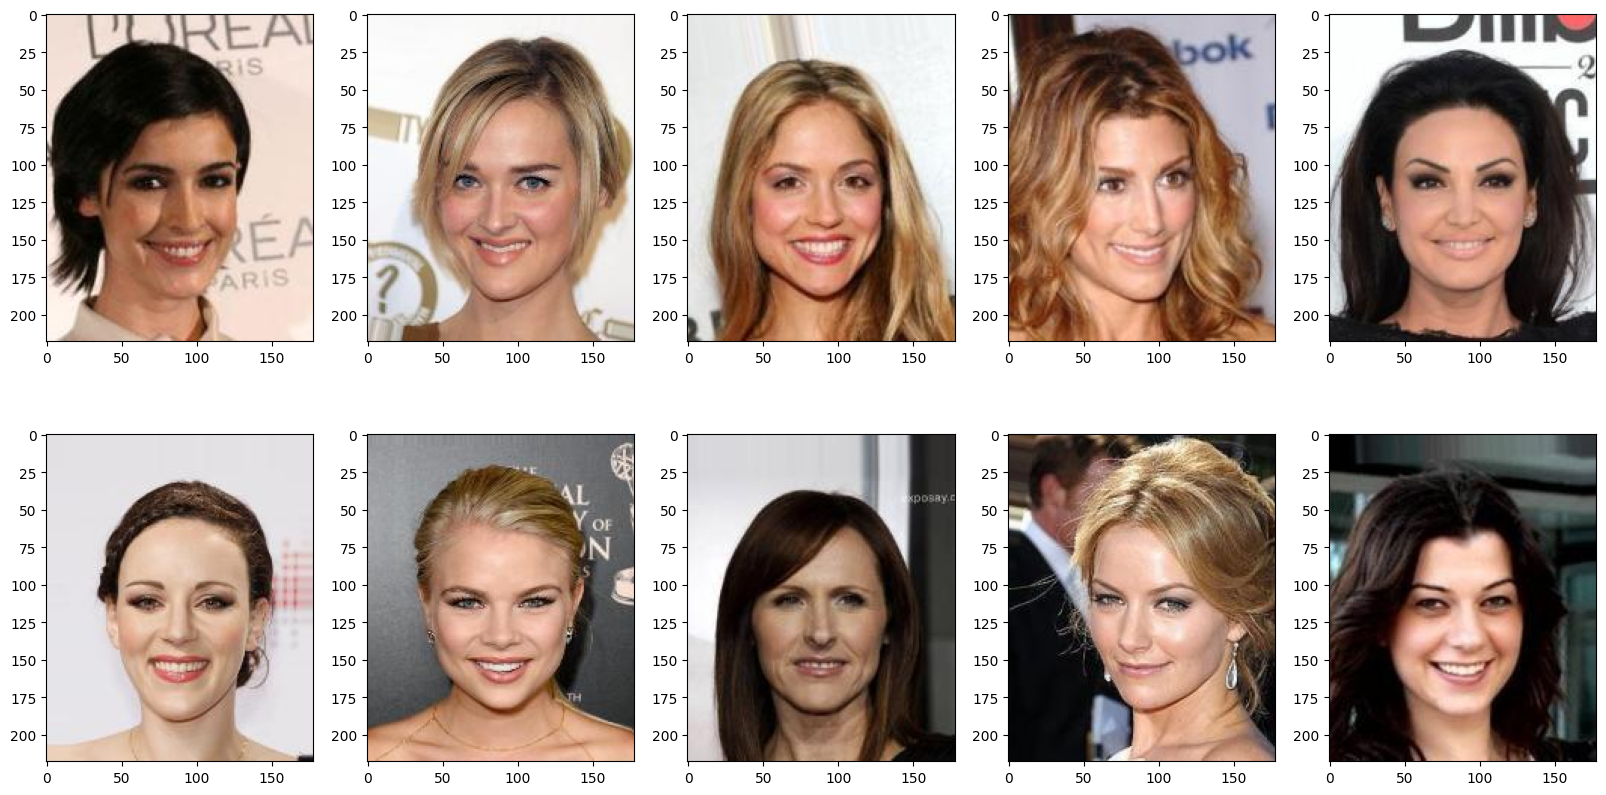

In [14]:
# show top 10 similar faces
fig = plt.figure(figsize=(20, 10))
for i, face in enumerate(top_10_faces):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(Image.open(face))
plt.show()